In [1]:
import os

# os.chdir("/Users/navneetsingh/Library/Mobile Documents/com~apple~CloudDocs/Work/GitHub-Repos/personal_repos/BITS/kd-slm-training")
os.chdir("/Users/navneetsingh/Library/Mobile Documents/com~apple~CloudDocs/Work/GitHub-Repos/personal_repos/BITS/bkps_from_jarvis_labs_exp/SLM_training_bits/pre-training/1march_bkp/kdsml")

In [2]:
import torch
from tqdm import tqdm
from models.teacher_model import TeacherModel
from models.student_model import StudentModel
from utils.loss_functions import KnowledgeDistillationLoss
from training.trainer import Trainer
from training.validator import Validator
from evaluation.evaluator import Evaluator
from utils.data_loader import DataLoader
import datetime

from transformers import logging as hf_logging
hf_logging.set_verbosity_error()


import matplotlib.pyplot as plt

/Users/navneetsingh/Softwares/CONDA_ENV/miniconda3/envs/kd-slm-training/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
r_path = '/Users/navneetsingh/Library/Mobile Documents/com~apple~CloudDocs/Work/GitHub-Repos/personal_repos/BITS/bkps_from_jarvis_labs_exp/SLM_training_bits/pre-training'

In [4]:
list_dirs = os.listdir(r_path)

In [5]:
list_dirs

['28feb_bkp',
 '1march_bkp',
 '.DS_Store',
 '11March_bkp2',
 'first_5epoch_bkp',
 '28feb_bkp2',
 '20feb_bkp',
 '25feb_bkp',
 '11March_bkp',
 '27feb_bkp',
 '2march_bkp',
 '23feb_bkp']

In [6]:
w_file = list_dirs[7]
print(w_file)

25feb_bkp


In [7]:
f_path = os.path.join(r_path, w_file, "kdsml", "older_chkpts")
checkpoint_path = os.path.join(f_path, 'checkpoint.pth')

In [8]:
os.listdir(f_path)

['checkpoint_epoch3.pth',
 'checkpoint_epoch9.pth',
 'checkpoint.pth',
 'checkpoint_epoch_13.pth']

In [12]:
device = torch.device("mps")

In [26]:
student_model = StudentModel().to(device)

In [27]:
checkpoint = torch.load(checkpoint_path, map_location=device)

In [21]:
checkpoint_path = os.path.join(r_path, list_dirs[3], "kdsml", "checkpoint.pth")
checkpoint = torch.load(checkpoint_path, map_location=device)

In [22]:
checkpoint.keys()

dict_keys(['epoch', 'student_model_state_dict', 'optimizer_state_dict', 'train_losses', 'val_losses', 'val_accuracies'])

In [23]:
checkpoint['epoch']

64

In [32]:
checkpoint['val_losses']

[1.0617238442103067,
 0.9423300743103027,
 0.8724827925364177,
 0.8286915103594462,
 0.8006035447120666]

In [9]:
def load_model_to_mps(chek_path):
    checkpoint = torch.load(chek_path, map_location=device)
    return checkpoint
    

In [10]:
def get_init_epochs():
    init_chk_path = os.path.join(r_path, 'first_5epoch_bkp', 'kdsml', 'older_chkpts')
    ch_path = os.path.join(init_chk_path, 'checkpoint_epoch_init_5epoch.pth')
    init_chk = torch.load(ch_path, map_location=device)

    return init_chk

In [13]:
chk_init = get_init_epochs()
print(chk_init.keys())
print(f"{chk_init['epoch']} :: {chk_init['val_accuracies']}")

dict_keys(['epoch', 'student_model_state_dict', 'optimizer_state_dict', 'train_losses', 'val_losses', 'val_accuracies'])
3 :: [24.982227194321517, 28.5345839510187, 30.55710168249227, 31.8786268923216, 32.7765489787253, 33.9876500876523]


In [14]:
def add_init_acc(act_dict):
    init_dict = get_init_epochs()
    for ind, val in enumerate(init_dict['val_accuracies']):
        act_dict[ind] = val
    return act_dict

In [15]:
def process_chk_folders(root_folder, proc_this=None):
    if proc_this is None:
        proc_this = ['11March_bkp2']
    look_up = set()
    train_losses = []
    val_losses = []
    val_accuracies = []
    list_dirs_bkps = os.listdir(root_folder)
    for d in list_dirs_bkps:
        if d not in proc_this:
            continue
        print(f'Processing {d} folder ...')
        cook_path = os.path.join(root_folder, d, 'kdsml', 'older_chkpts')
        for ll in os.listdir(cook_path):
            if ll not in look_up:
                look_up.add(ll)
                chk_path = os.path.join(cook_path, ll)
                print(f'\t checkpoints processing {chk_path}')
                dict_data = load_model_to_mps(chk_path)
                print(f'epoch : {dict_data["epoch"]} :: train_losses : {dict_data["val_accuracies"]}')
                [train_losses.append(tl) for tl in dict_data["train_losses"]]
                [val_losses.append(vl) for vl in dict_data["val_losses"]]
                
                dict_acc = add_init_acc(dict_data['val_accuracies'])
                [val_accuracies.append(va) for va in dict_acc]

        print('----'*20)
    return train_losses, val_losses, val_accuracies

In [16]:
tl_losses, vl_losses, va_acc = process_chk_folders(r_path)

Processing 11March_bkp2 folder ...
	 checkpoints processing /Users/navneetsingh/Library/Mobile Documents/com~apple~CloudDocs/Work/GitHub-Repos/personal_repos/BITS/bkps_from_jarvis_labs_exp/SLM_training_bits/pre-training/11March_bkp2/kdsml/older_chkpts/checkpoint_epoch65.pth
epoch : 64 :: train_losses : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.00860809999063, 34.4037430355401, 34.756443675361105, 35.04246185046595, 35.27777930859653, 35.50538144023102, 35.810687931576076, 35.953421471753636, 36.123709749417216, 36.289038174333314, 36.46538849424382, 36.51994687446612, 36.66929355164034, 36.83903073455419, 36.923899326011124, 36.998297117223366, 37.11072044616631, 37.24904522834611, 37.25510727059304, 37.41878241125997, 37.4116181795136, 37.49207801297277, 37.58135536242746, 37.569782372683335, 37.69708525986873, 37.77368743007985, 37.784158230324536, 37.80069107281615, 37.86296477953455, 37.967672781981406, 38.07789173192547, 37.98971657197022, 38.033253057198124, 38.12308150140253, 38.1120596

> Processing 28feb_bkp folder ...

    - checkpoints processing /Users/navneetsingh/Library/Mobile Documents/com~apple~CloudDocs/Work/GitHub-Repos/personal_repos/BITS/bkps_from_jarvis_labs_exp/SLM_training_bits/pre-training/28feb_bkp/kdsml/older_chkpts/checkpoint_epoch29.pth
epoch : 28 :: train_losses : [1.1998817267743025, 1.0050957922908392, 0.9182086968286471, 0.8632902602919124, 0.8279462246732279, 0.8052247083661231, 0.7867623397233812, 0.7729125889526172, 0.7607178708707745, 0.7540443427522074, 0.7431137880479748, 0.7374988811598583, 0.7307097713378343, 0.7243821087208662, 0.7213905880058353, 0.7148289036005735, 0.7118575088002465, 0.7081670660356228, 0.7031283725730397, 0.701299158280546, 0.6991976825012403, 0.6970037053931843, 0.6914924576878547, 0.6906105505810542, 0.6879374543035572, 0.6855161270634694, 0.686383733746003, 0.6815489131957293, 0.6800208989869464]

--------------------------------------------------------------------------------

> Processing 1march_bkp folder ...

    - checkpoints processing /Users/navneetsingh/Library/Mobile Documents/com~apple~CloudDocs/Work/GitHub-Repos/personal_repos/BITS/bkps_from_jarvis_labs_exp/SLM_training_bits/pre-training/1march_bkp/kdsml/older_chkpts/checkpoint_epoch44.pth
epoch : 43 :: train_losses : [1.1998817267743025, 1.0050957922908392, 0.9182086968286471, 0.8632902602919124, 0.8279462246732279, 0.8052247083661231, 0.7867623397233812, 0.7729125889526172, 0.7607178708707745, 0.7540443427522074, 0.7431137880479748, 0.7374988811598583, 0.7307097713378343, 0.7243821087208662, 0.7213905880058353, 0.7148289036005735, 0.7118575088002465, 0.7081670660356228, 0.7031283725730397, 0.701299158280546, 0.6991976825012403, 0.6970037053931843, 0.6914924576878547, 0.6906105505810542, 0.6879374543035572, 0.6855161270634694, 0.686383733746003, 0.6815489131957293, 0.6800208989869464, 0.6791381705383008, 0.6772016667845574, 0.6764030255377292, 0.6728785050016912, 0.6731417542492801, 0.6710477780550719, 0.6707544524222613, 0.6688057291236791, 0.6666826313869519, 0.6672092420133677, 0.6664451513778079, 0.6627733266489072, 0.6617983227257024, 0.6613500689241019, 0.6604353014549071]

--------------------------------------------------------------------------------

> Processing 28feb_bkp2 folder ...

    checkpoints processing /Users/navneetsingh/Library/Mobile Documents/com~apple~CloudDocs/Work/GitHub-Repos/personal_repos/BITS/bkps_from_jarvis_labs_exp/SLM_training_bits/pre-training/28feb_bkp2/kdsml/older_chkpts/checkpoint_epoch38.pth
epoch : 37 :: train_losses : [1.1998817267743025, 1.0050957922908392, 0.9182086968286471, 0.8632902602919124, 0.8279462246732279, 0.8052247083661231, 0.7867623397233812, 0.7729125889526172, 0.7607178708707745, 0.7540443427522074, 0.7431137880479748, 0.7374988811598583, 0.7307097713378343, 0.7243821087208662, 0.7213905880058353, 0.7148289036005735, 0.7118575088002465, 0.7081670660356228, 0.7031283725730397, 0.701299158280546, 0.6991976825012403, 0.6970037053931843, 0.6914924576878547, 0.6906105505810542, 0.6879374543035572, 0.6855161270634694, 0.686383733746003, 0.6815489131957293, 0.6800208989869464, 0.6791381705383008, 0.6772016667845574, 0.6764030255377292, 0.6728785050016912, 0.6731417542492801, 0.6710477780550719, 0.6707544524222613, 0.6688057291236791, 0.6666826313869519]

--------------------------------------------------------------------------------

> Processing 20feb_bkp folder ...

    checkpoints processing /Users/navneetsingh/Library/Mobile Documents/com~apple~CloudDocs/Work/GitHub-Repos/personal_repos/BITS/bkps_from_jarvis_labs_exp/SLM_training_bits/pre-training/20feb_bkp/kdsml/older_chkpts/checkpoint.pth
epoch : 4 :: train_losses : [1.1998817267743025, 1.0050957922908392, 0.9182086968286471, 0.8632902602919124, 0.8279462246732279]

--------------------------------------------------------------------------------

> Processing 25feb_bkp folder ...

    - checkpoints processing /Users/navneetsingh/Library/Mobile Documents/com~apple~CloudDocs/Work/GitHub-Repos/personal_repos/BITS/bkps_from_jarvis_labs_exp/SLM_training_bits/pre-training/25feb_bkp/kdsml/older_chkpts/checkpoint_epoch3.pth
epoch : 2 :: train_losses : [1.2018322986296632, 1.006790518151088, 0.9201045636764982]

    - checkpoints processing /Users/navneetsingh/Library/Mobile Documents/com~apple~CloudDocs/Work/GitHub-Repos/personal_repos/BITS/bkps_from_jarvis_labs_exp/SLM_training_bits/pre-training/25feb_bkp/kdsml/older_chkpts/checkpoint_epoch9.pth
epoch : 8 :: train_losses : [1.1998817267743025, 1.0050957922908392, 0.9182086968286471, 0.8632902602919124, 0.8279462246732279, 0.8052247083661231, 0.7867623397233812, 0.7729125889526172, 0.7607178708707745]

    - checkpoints processing /Users/navneetsingh/Library/Mobile Documents/com~apple~CloudDocs/Work/GitHub-Repos/personal_repos/BITS/bkps_from_jarvis_labs_exp/SLM_training_bits/pre-training/25feb_bkp/kdsml/older_chkpts/checkpoint_epoch_13.pth
    
epoch : 12 :: train_losses : [1.1998817267743025, 1.0050957922908392, 0.9182086968286471, 0.8632902602919124, 0.8279462246732279, 0.8052247083661231, 0.7867623397233812, 0.7729125889526172, 0.7607178708707745, 0.7540443427522074, 0.7431137880479748, 0.7374988811598583, 0.7307097713378343]

--------------------------------------------------------------------------------

> Processing 27feb_bkp folder ...

--------------------------------------------------------------------------------

> Processing 23feb_bkp folder ...

    checkpoints processing /Users/navneetsingh/Library/Mobile Documents/com~apple~CloudDocs/Work/GitHub-Repos/personal_repos/BITS/bkps_from_jarvis_labs_exp/SLM_training_bits/pre-training/23feb_bkp/kdsml/older_chkpts/checkpoint_9epoch.pth
epoch : 8 :: train_losses : [1.1998817267743025, 1.0050957922908392, 0.9182086968286471, 0.8632902602919124, 0.8279462246732279, 0.8052247083661231, 0.7867623397233812, 0.7729125889526172, 0.7607178708707745]

--------------------------------------------------------------------------------

In [17]:
print(f'{len(tl_losses)} :: {len(vl_losses)} :: {len(va_acc)}')

65 :: 65 :: 65


In [33]:
!pwd


/Users/navneetsingh/Library/Mobile Documents/com~apple~CloudDocs/Work/GitHub-Repos/personal_repos/BITS/bkps_from_jarvis_labs_exp/SLM_training_bits/pre-training/1march_bkp/kdsml


In [18]:
def save_training_plot(train_losses, val_losses, val_accuracies):
    """Save the training metrics plot to a file in the 'plots' directory using a descriptive naming convention."""
    # Create plots directory if it doesn't exist
    os.makedirs("plots", exist_ok=True)
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs (pre-training phase)')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, label='Val Accuracy', marker='o', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy over Epochs (pre-training phase)')
    plt.legend()

    plt.tight_layout()
    # Create a timestamp for the file name
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    # Use a naming convention: training_metrics_epoch{last_epoch}_{timestamp}.png
    filename = f"plots/training_metrics_epoch{len(train_losses)}_{timestamp}.png"
    print(filename)
    plt.savefig(filename)
    # plt.show()
    print(f"Training metrics plot saved as: {filename}")

In [20]:
!pwd

/Users/navneetsingh/Library/Mobile Documents/com~apple~CloudDocs/Work/GitHub-Repos/personal_repos/BITS/bkps_from_jarvis_labs_exp/SLM_training_bits/pre-training/1march_bkp/kdsml


plots/training_metrics_epoch65_2025-03-19_15-08-39.png
Training metrics plot saved as: plots/training_metrics_epoch65_2025-03-19_15-08-39.png


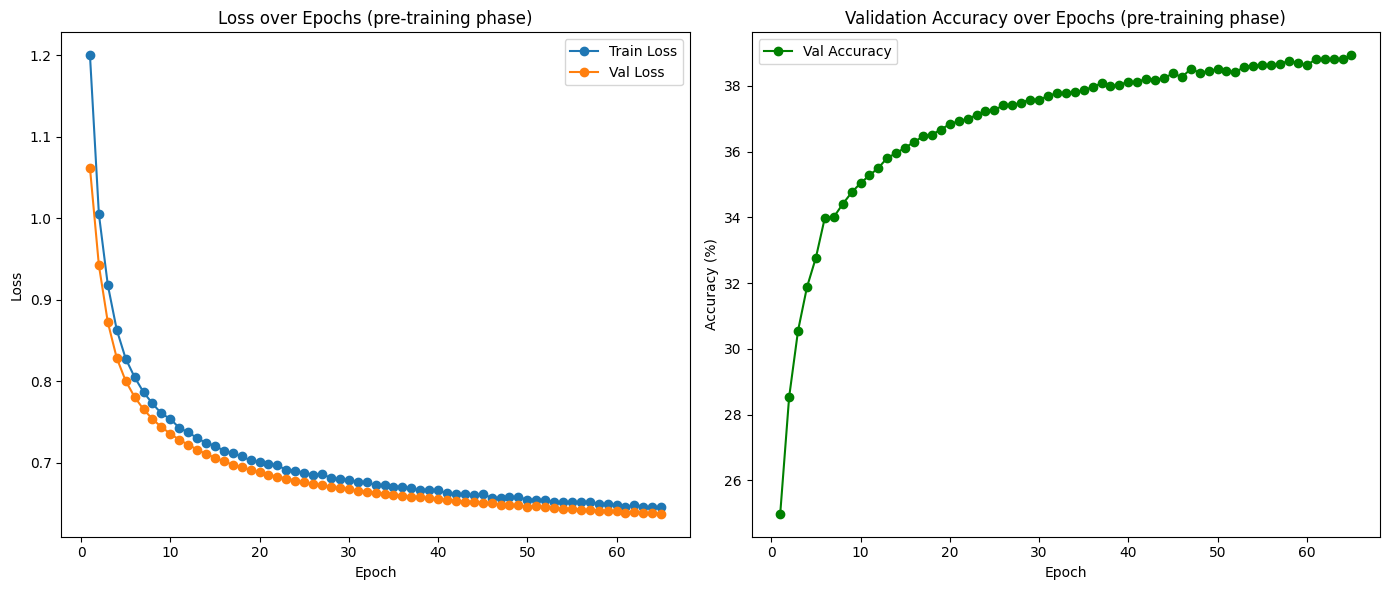

In [19]:
save_training_plot(tl_losses, vl_losses, va_acc)

plots/training_metrics_epoch56_2025-03-11_09-51-10.png
Training metrics plot saved as: plots/training_metrics_epoch56_2025-03-11_09-51-10.png


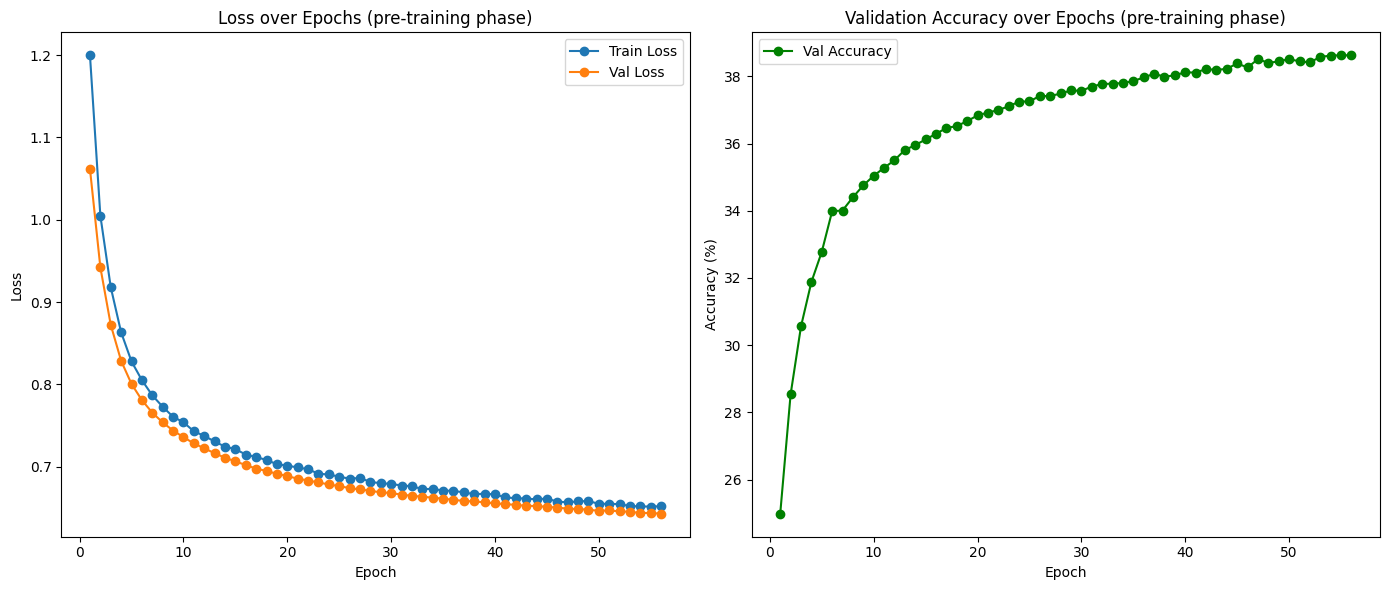

In [35]:
save_training_plot(tl_losses, vl_losses, va_acc)

In [90]:
proc_this = ['2march_bkp']
tl_losses, vl_losses, va_acc = process_chk_folders(r_path, proc_this=proc_this)

Processing 2march_bkp folder ...
	 checkpoints processing /Users/navneetsingh/Library/Mobile Documents/com~apple~CloudDocs/Work/GitHub-Repos/personal_repos/BITS/bkps_from_jarvis_labs_exp/SLM_training_bits/pre-training/2march_bkp/kdsml/older_chkpts/checkpoint_epoch48.pth
epoch : 47 :: train_losses : [1.1998817267743025, 1.0050957922908392, 0.9182086968286471, 0.8632902602919124, 0.8279462246732279, 0.8052247083661231, 0.7867623397233812, 0.7729125889526172, 0.7607178708707745, 0.7540443427522074, 0.7431137880479748, 0.7374988811598583, 0.7307097713378343, 0.7243821087208662, 0.7213905880058353, 0.7148289036005735, 0.7118575088002465, 0.7081670660356228, 0.7031283725730397, 0.701299158280546, 0.6991976825012403, 0.6970037053931843, 0.6914924576878547, 0.6906105505810542, 0.6879374543035572, 0.6855161270634694, 0.686383733746003, 0.6815489131957293, 0.6800208989869464, 0.6791381705383008, 0.6772016667845574, 0.6764030255377292, 0.6728785050016912, 0.6731417542492801, 0.6710477780550719, 0

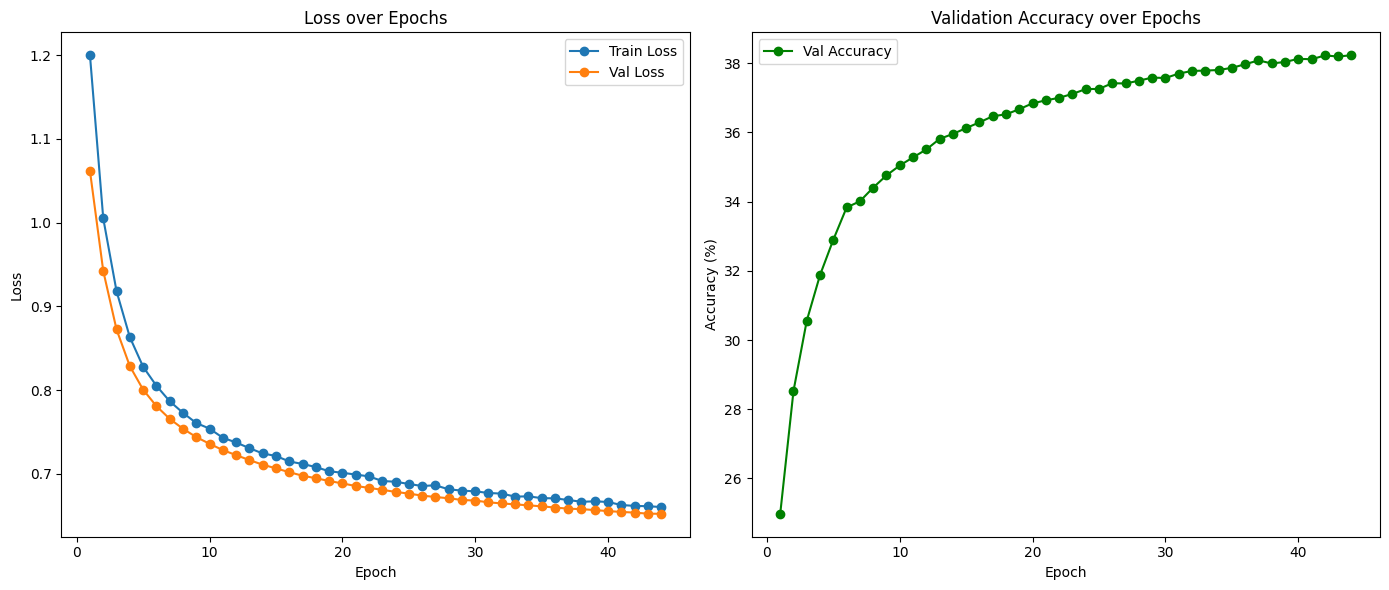

Training metrics plot saved as: plots/training_metrics_epoch44_2025-03-02_15-49-49.png


In [125]:
save_training_plot(tl_losses, vl_losses, va_acc)

In [93]:
print(va_acc)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 34.00860809999063, 34.4037430355401, 34.756443675361105, 35.04246185046595, 35.27777930859653, 35.50538144023102, 35.810687931576076, 35.953421471753636, 36.123709749417216, 36.289038174333314, 36.46538849424382, 36.51994687446612, 36.66929355164034, 36.83903073455419, 36.923899326011124, 36.998297117223366, 37.11072044616631, 37.24904522834611, 37.25510727059304, 37.41878241125997, 37.4116181795136, 37.49207801297277, 37.58135536242746, 37.569782372683335, 37.69708525986873, 37.77368743007985, 37.784158230324536, 37.80069107281615, 37.86296477953455, 37.967672781981406, 38.07789173192547, 37.98971657197022, 38.033253057198124, 38.12308150140253, 38.112059606408124, 38.22007417735331, 38.191417250367856, 38.22668731434995, 38.38540260226941, 38.264712852080656, 38.51435877370396, 38.401935444761016]
